<a href="https://colab.research.google.com/github/lijerrymagic/MLColabAssignment/blob/master/multArmBanditProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Andre Cianflone**

## Thompson sampling
Thompson sampling is an ingenious algorithm that implicitly balances exploration and exploitation based on quality and uncertainty. Let's say we sample a 3-armed bandit and model the probability that each arm gives us a positive reward. The goal is of course to maximize our rewards by pulling the most promising arm. Assume at the current timestep arm-3 has mean reward of 0.9 over 800 pulls, arm-2 has mean reward of 0.8 over 800 pulls, and arm-1 has mean reward of 0.78 over 10 pulls. So far, arm-3 is clearly the best. But if we were to explore, would we choose arm-2 or arm-1? An $\epsilon$-greedy algorithm would, with probability $\epsilon$, just as likely choose arm-3, arm-2, or arm-1. However, arm-2 has been examined many times, as many as arm-1, and has a mean reward lower than arm-1. Selecting arm-2 seems like a wasteful exploratory action. Arm-1 however, has a lower mean reward than either arm-2 or arm-3, but has only been pulled a few times. In other words, arm-1 has a higher chance of being a better action than arm-3 when compared to arm-2, since we are more *uncertain* about its true value. The $\epsilon$-greedy algorithm completely misses this point. Thompson sampling, on the other hand, incorporates uncertainty by modelling the bandit's Bernouilli parameter with a prior beta distribution.

The beauty of the algorithm is that it always chooses the action with the highest expected reward, with the twist that this reward is weighted by *uncertainty*. It is in fact a Bayesian approach to the bandit problem. In our Bernouilli bandit setup, each action $k$ returns reward of 1 with probability $\theta_k$, and 0 with probability $1-\theta_k$. At the beginning of a simulation, each $\theta_k$ is sampled from a uniform distribution $\theta_k \sim Uniform(0,1)$ with $\theta_k$ held constant for the rest of that simulation (in the stationary case). The agent begins with a prior belief of the reward of each arm $k$ with a beta distribution, where $\alpha = \beta = 1$. The prior probability density of each $\theta_k$ is:

$$
p(\theta_k) = \frac{\Gamma(\alpha_k + \beta_k)}{\Gamma(\alpha_k)\Gamma(\beta_k)} \theta_k^{\alpha_k -1} (1-\theta_k)^{\beta_k-1}
$$

An action is chosen by first sampling from the beta distribution, followed by choosing the action with highest mean reward:
$$
x_t = \text{argmax}_k (\hat{\theta}_k), \quad \hat{\theta}_k \sim \text{beta}(\alpha_k, \beta_k)
$$

According to Bayes' rule, an action's posterior distribution is updated depending on the reward $r_t$ received:
$$
(\alpha_k, \beta_k) = (\alpha_k, \beta_k) + (r_t, 1-r_t)
$$

Thus the actions' posterior distribution are constantly updated throughout the simulation. We will measure the Thompson algorithm by comparing it with the $\epsilon$-greedy and Upper Confidence Bound (UCB) algorithms using *regret*. The per-period regret for the Bernouilli bandit problem is the difference between the mean reward of the optimal action minus the mean reward of the selected action:
$$
\text{regret}_t(\theta) = \max_k \theta_k - \theta_{x_t}
$$

First we setup the necessary imports and the standard k-armed bandit. The *get_reward_regret* samples the reward for the given action, and returns the regret based on the true best action.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret


We implement the two beta algorithms from [1], although we focus only on the Thompson algorithm. For the Bernouilli-greedy algorithm, the Bernouilli parameters are the expected values of the Beta distribution, i.e.:
$$
\mathbb{E}(x_k) = \frac{\alpha_k}{(\alpha_k + \beta_k)}
$$

The Thompson algorithm follows the pseudocode below, based on [1]


**Algorithm: Thompson($K$,$\alpha$, $\beta$)**  
for $t$ = 1,2, ..., do  
  &nbsp;&nbsp; // sample action parameter from beta distribution  
  &nbsp;&nbsp; for $k = 1, \dots, K$ do  
  &nbsp;&nbsp; &nbsp;&nbsp; Sample $\hat{\theta}_k \sim \text{beta}(\alpha_k, \beta_k)$  
  &nbsp;&nbsp; end for
  
  &nbsp;&nbsp; // select action, get reward  
  &nbsp;&nbsp; $x_t \leftarrow \text{argmax}_k \hat{\theta}_k$  
  &nbsp;&nbsp; $r_t \leftarrow \text{observe}(x_t)$  
  
  &nbsp;&nbsp; // update beta parameters  
  &nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t})+(r_t, 1-r_t)$  
end for
  

For comparison, we also implement the $\epsilon$-greedy algorithm and Upper Confidence Bound (UBC) algorithm. The implementations are based on [2] (pages 24-28). The $\epsilon$-greedy algorithm is straightforward and explained briefly above. Note in this implementation we make use of the incremental update rule. That is, to update the $Q$-value of each action, we maintain a count of each action. For action $k$ taken at time $t$:
$$
\begin{align}
r_t &\leftarrow \text{observe}(k) \\
N(k) &\leftarrow N(k) + 1 \\
Q(k) &\leftarrow Q(k) + \frac{1}{N(k)}[r_t-Q(k)] \\
\end{align}
$$

In [5]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

The UCB action selection is different to the $\epsilon$-greedy. Like the Thompson algorithm, it includes a measure of uncertainty. The selected action follows the rule:
$$
A_t = \text{argmax}_a \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t (a)}} \right]
$$

Where $N_t (a)$ is the number of times action $a$ has been selected up to time $t$. As the denominator grows in the square root expression, the added effect on $Q_t(a)$ diminishes. This uncertainty measure is weighed by the hyperparameter $c$. The disadvantage is that, unlike the Thompson algorithm, this uncertainty hyperparameter requires tuning. Fundamentally, **the UCB uncertainty is deterministic and beneficial**, whereas **in the Thompson case, uncertainty increases the expected reward variance**. Since the Thompson algorithm samples the mean rewards from a beta distribution, the actions with high variance may not only have a higher chance of being chosen, but may also have a lower chance. 

In [6]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

Below are some helper functions. The function *simulate* will simulate the learning for a single algorithm and return the mean regrets over a number of trials. The *experiment* function runs the simulations over all algorithms and plots their mean regrets

In [7]:

def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

## Experiments
For all experiments, in each trial the agents are allowed 1000 timesteps to maximize reward. We perform 5000 trials for each experiment.

### Baseline
In this first experiment, we aim for a standard setup, inspired by the bandit testbed in Chapter 2 of [2]. We set $\epsilon=0.1$ for the $\epsilon$-greedy algorithm, and $c=2$ for UCB. As can be seen in the chart below, the Thompson and $\epsilon$-greedy agents quickly converge to a steady regret value after only 200 steps. The UCB agent on the other hand very slowly decreases, lagging behind the two other agents, and continues in its downward trend even at step 1000. This suggests the non-Thompson agents could benefit from parameter tuning, whereas the Thompson agent works well right off the bat.

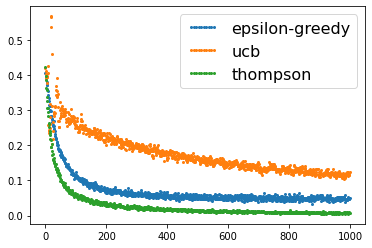

In [ ]:

# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)


### Being greedier
After fiddling with UCB's $c$ parameter, we can see that if it is set to 0.1, it quickly converges to a low regret value, after only a few dozen steps and now outperforms $\epsilon$-greedy with very little variance. Note that at first it outperforms Thompson, but not in the long run. Decreasing UCB's $c$ basically decreased the "premium" the agent adds to uncertainty. This encourages UCB to be more "greedy", hence why it converges quickly. Yet it still does not outperform Thompson. Given this intuition, we also make $\epsilon$-greedy greedier, decreasing its hyperparameter to 0.03. We can see that after 1000 steps, it does outperform the previous $\epsilon$-greedy, but only marginally. Also, this comes at the cost of converging much more slowly. We do not observe the massive swing as observed with UCB, even if we continue to lower $\epsilon$.
It's possible that given only 10 actions, being greedy is a better solution, and exploring is costly and unnecessary, leading us to the next experiment.

In [ ]:

# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.01
ucb_c = 0.1
stationary=True
experiment(arm_count)

NameError: ignored

### Large action space
In this setting, we increase the number of actions from 10 to 200, leaving the other parameters equal to our baseline. The $\epsilon$-greedy agent barely budges in its learning pattern when compared to the baseline. The Thompson agent very slowly, but surely, decreases regret to eventually outperform $\epsilon$-greedy around step 700, another vote of confidence for Thompson. On the other hand, UCB is drastically unstable and diverges. This behaviour is not only due to the increase in action space, but due to the fact that the Bernouilli reward probabilities are so close to each other. Recall that regret is calculated as the difference between the optimal $\theta_k$ and the action $\hat{\theta}_k$. Since the true $\theta_k$ are sampled from a uniform distribution, they are evenly spread between 0 and 1. The greedy algorithm need only sample a few values and has a high probability of its most favourable action's estimated reward probability being close to the true optimal reward probability, ensuring it a low regret, even if it never chooses the optimal action. Thompson and UCB, on the other hand, with their emphasis on exploration, give a high premium to exploring actions not yet seen. Since there are so many actions, and since the mean rewards are evenly distributed between 0 and 1, there is a high cost of constantly exploring actions with rewards close to 0. Noticeably, the Thompson algorithm is incredibly stable across time, despite the large action space. Due to its sampling nature, it has a lower probability than UCB of constantly taking suboptimal actions.

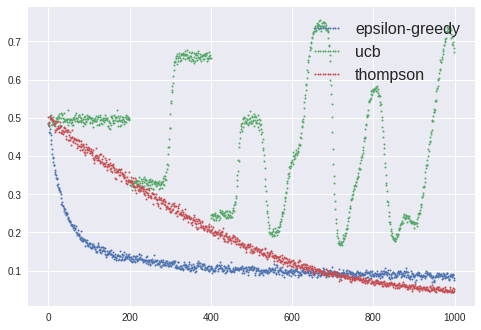

In [ ]:
# Experiment 3
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

We now lower UCB's $c$ variable and observe a dramatic increase in stability, which even leads it to outperform all other algorithms. However, the Thompson agent still seems to be on a decreasing regret trend around 1000 steps without having converged, in between $\epsilon$-greedy and UCB.

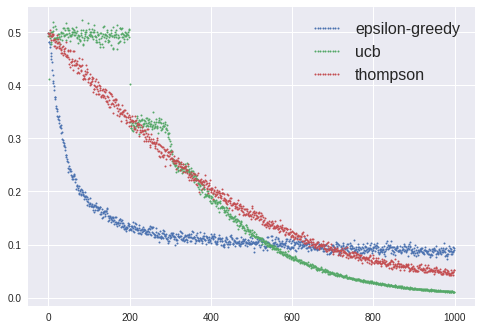

In [ ]:
# Experiment 4
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count)

In the graph below, increasing the timesteps to 3000 confirms that Thompson and UCB closely converge.

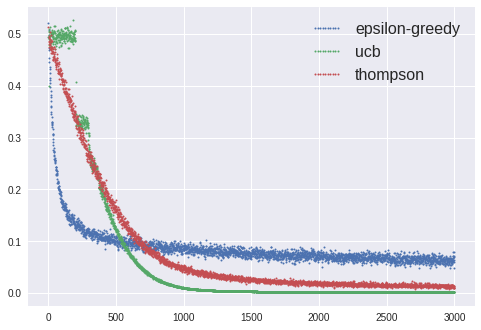

In [ ]:
# Experiment 5
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)

### Non-stationarity
We now reset our parameters to the baseline settings: 10-arm bandit, $\epsilon=0.1$ and UCB-c value of 2. However, we now set the environment to being non-stationary. Actually, after every 100 steps, the bandit resamples the action Bernouilli parameters. This places special emphasis on exploration. An algorithm that converges to an action and does not emphasize exploration will perform quite poorly as the true reward distribution changes over time. Below we see a clear jump in regret every time the true bandit parameters are resampled (every 100 steps). While the $\epsilon$-greedy and Thompson's regret quickly decrease, on average they increase over time. On the other hand, UCB reacts much more quickly to the bandit non-stationarity, and actually continues to improve in regret over time, no doubt due to its higher emphasis on exploration. We confirm this in the next experiment.

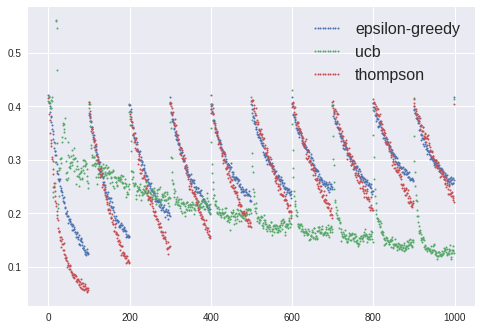

In [ ]:
# Experiment 6
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

We now set UCB's $c$ parameter to 0.1 as we did in Experiment 2. Due to Experiment 2's setup, we concluded a greedier version of UCB would perform better in that setup, which it did. In the current setup, we can observe that the greedy UCB performs quite poorly and much like the other algorithms. Since we prefer a more exploratory algorithm, we fine tune $\epsilon$-greedy to be much less greedy and observe that it does not perform well. In fact, after trying for $\epsilon \in \{0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9\}$,  $\epsilon$-greedy performs the same as in the chart below.

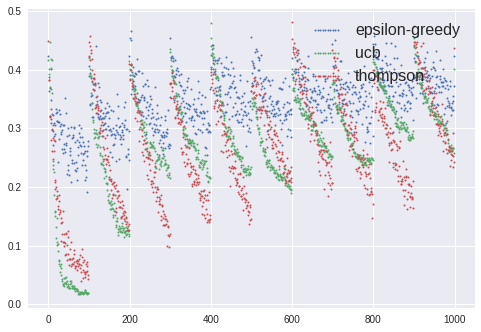

In [ ]:
# Experiment 7
arm_count = 10 # number of arms in bandit
epsilon = 0.6
ucb_c = 0.1
stationary=False
experiment(arm_count)

We have seen the advantages and disadvantages of various algorithms. The Thompson algorithm has been shown to perform quite well in various settings without any necessary parameter tuning to boot. In some cases, UCB performed close to Thompson, but required fine tuning. Exceptionally, UCB dealt better than Thompson in the non-stationary setup, but only after tuning its hyperparameter. Notably, in no cases was $\epsilon$-greedy the best performing agent.

## References
[1]: Russo, Daniel, Benjamin Van Roy, Abbas Kazerouni, and Ian Osband. "A Tutorial on Thompson Sampling." arXiv preprint arXiv:1707.02038 (2017). [link](https://arxiv.org/abs/1707.02038)

[2]: Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. Vol. 1, no. 1. Cambridge: MIT press, 1998.

------------------------------------------------------------
## **Analysis and extension**

**Understanding and explanation of current notebook implementation:**

The problem that I understand of multi-armed bandit problem, is to find the maximum reward(which is the money we will get eventually from the original problem) after a bunch of "actions", which is equal to pull the trigger among a number of slot machines. The difficulty of this problem is that we dont know the probability of the winning rate for each of the machine, or we can say, the conversion rate for each machine. So that it is hard to "predict" which machine will give us the best reward. Also there also exist a problem betwwen "exporation" and "expoitation". Exploration means whether to explore new machines that potentially give better reward. Exploitation basically means just get the best reward from the machines that already seen.


And in this notebook, it first define the bandit, which act as the slot machine that we will do actions on. Below are the original code with some annotations and understanding.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

# Zeyu: stationary here means if the conversion rate for each machine is static
# if it is false, each mechaine will change its conversion rate theta after
# each action
stationary=True
class Bandit_Annotated():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    # Zeyu: timestep acts as the total number of actions or the upper limit of
    # all actions
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  # Zeyu: theta here represents the conversion rate of each machine
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    # Zeyu: each time its called, it performed one action already
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling

    # Zeyu: using uniform distribution to siumulate the process of pulling 
    # the trigger, if if greater than conversion rate theta, get 1 as reward, 
    # 0 otherwise
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    # Zeyu: we define the loss as the difference between the maximum average
    # conversion rate and the rate of the arm we pull
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

Then we first look at the epsilon-greedy algorithm which is the easiest to understand.

In [ ]:
# Zeyu: The "exploration rate" set here as e
epsilon = 0.3
class EpsilonGreedy_Annotated():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    # Zeyu: the epsilon value acts like a threshhold 
    # for decisions, the larger the value is, the more 
    # exploration the algorithm will do
    self.epsilon = epsilon 
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    # Zeyu: list of expectations (average reward) for each machine
    self.Q = np.zeros(self.arm_count) # q-value of actions
    # Zeyu: list of numbers of actions happened on each machine
    self.N = np.zeros(self.arm_count) # action count
                                      
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  # Zeyu: each time it gets an action, if will check if 
  # the probabilty is greater than epsilon. if it is, it 
  # will exploit and choose machine the the maxmimum 
  # conversion rate theta. If it is not, then it will 
  # randomly choose one from all arms
  def get_action(self): 
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    # Zeyu: calling the bandit method get_reward_rate() since the loss and 
    # reward are the same definition across alogorithms 
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    # Zeyu: update N list with action plus one on a specific arm
    self.N[arm] += 1 # increment action count
    # Zeyu: update Q list with new average reward on a specific arm
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

We can easily see the drawback of e greedy that it is too random. One scenario that most probably would happend is that lets say we have two machines one called M1 with 0.9 conversion rate and the other one called M2 with just 0.1 rate. However, by randomly picking, it is possible that the second machine is picked by the algo for the first time. And, if we set e to be kinda small, it will keep "exploit" the second machine since it is the one we've seen with maximum average reward. And since e is small, the machine withe higher theta may not even get a chance to be picked. So clearyly this algorithm does not compare the theta for all machines when making decisions.

Lets then look at thompson sampling which will potentialy solve the problem mentioned above.It basically help us to update and predict the probability of conversion rate by using Beta distribution which is a distribution of probability for the machine based on the rewards getting from one action. So it will be more accurate when perform next action.

In [ ]:
class BetaAlgo_Annotated():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    # Zeyu: Initialize alpha and beta which acts as the input for beta 
    # distribution with all ones for later use
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    # Zeyu: update the value of alpha and beta by increasing alpha value by 
    # reward and decrease beta value by 1-reward 
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    # Zeyu: using the updated alpha and beta as the input for beta distribution
    # to predict the new conversion rate
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

And I choose to skip UCB because it is not so relevant to what I am going to extend.

### **First extension: Thompson plus e-Greedy**
The frist extension I 'm going to do is to combine empsilon greedy algorithm with thompson sampling. The reason is that to me thompson sampling is more like an algorithm that will give us the more accurate conversion rate after each action by applying its beta distribution and always pick the one with highest conversin rate. However epsilon greedy algorithm gives us a strategy to choose arms base on a threshold. So I was wondering what if those two algorithms are combined together. I am expecting it will perform better than normal e-greedy but will be not as good as thompson samling since it sometimes not giving the action with the best conversion rate. The modified algorithm shows below.

In [16]:
class BetaAlgo_Thompson_Plus_Greedy():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward
  
class BernThompsonEGreedy(BetaAlgo_Thompson_Plus_Greedy):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson with greedy strategy'
  
  def get_action(self):

    """ Bernouilli parameters are sampled from the beta"""
    # Zeyu: previously here it select the machine with maximum conversion rate
    # now we apply a e greedy strategy here to select based on a epsilon
    if np.random.uniform(0,1) > global_e_thompson:
      theta = np.random.beta(self.alpha, self.beta)
      action = theta.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action

**Experiment**

We can use the same experiment set up mentioned above and try to compare the performance of each algorithms but without UCB.



In [ ]:
import time
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  t0 = time.time()
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  t1 = time.time()
  total_time = t1 - t0
  return mean_regrets, total_time

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  # Zeyu: here we only include those three alogorithms to compare
  algos = [EpsilonGreedy, BernThompson, BernThompsonEGreedy]
  times = {}
  regrets = []
  names = []
  for algo in algos:
    mean_regret = simulate(simulations, timesteps, arm_count, algo)
    regrets.append(mean_regret[0])
    times[algo.name()] = mean_regret[1]
    names.append(algo.name())
  multi_plot_data(regrets, names)
  print_time(algos, times)

# Zeyu: new function added to calculate running time for each algo
def print_time(algos, times):
  for algo in algos:
    print(algo.name() + " time(estimated for all simulations) is: " + str(times[algo.name()]))

First we set up a baseline which choose both the epsilon and the epsilon(note as global_e_thompson) used in thompson_plus_greedy algorithm equals to 0.1. We can see that the new thompson_plus_greedy algorithm converges faster than normal greedy but slower than the thompson algorithm. However the regret it converges to in the end showing it has the same performance as normal epsilon greedy which seems not impoving anything in regret perspective from the normal epsilon greedy.

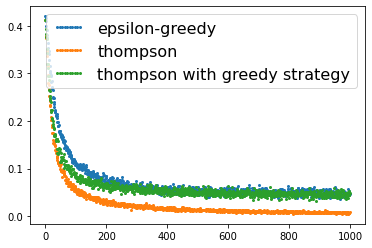

epsilon-greedy time(estimated for all simulations) is: 22.51748561859131
thompson time(estimated for all simulations) is: 32.187607526779175
thompson with greedy strategy time(estimated for all simulations) is: 35.319602966308594


In [ ]:

# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.1
global_e_thompson = 0.1
stationary=True
experiment(arm_count)


Then we perform the second experiment which only reduced the epsilon value in the new thompson_plus_greedy algorithm to 0.05. It can be seen that now the regret value it converges in the end does look better than normal epsilon greedy but still not as good as thompson sampling. It actually sits in between those two algorithms and does converges as fast as thompson. The reason it behaves like it is that it still using thompson to predict the conversion rate however sometimes it is not taking a action with highest conversion rate because of the epsilon added. Also if we keep decreasing the value of epsilon in new algorithm, which means it will have less probability to randomly choose, so when it close tio zero, it will basically become same as thopson algorithm. So the result showing is as expected.

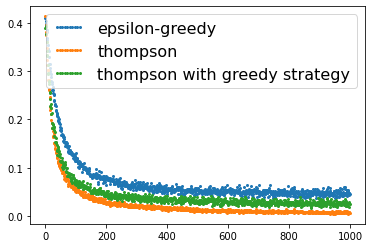

epsilon-greedy time(estimated for all simulations) is: 22.011756896972656
thompson time(estimated for all simulations) is: 32.04098987579346
thompson with greedy strategy time(estimated for all simulations) is: 35.68357610702515


In [ ]:

# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.1
global_e_thompson = 0.05
stationary=True
experiment(arm_count)


Till now we havent use the estimated time we measured for algorithms yet and we can't see anything good with the new algorithm which leads us to the third experiment showing below.
Now we modify the epsilons back to baseline. But increasing the arm count to 200 which means there are more machines or arms to choose from. We can see that the thompson and thopson_plus_greedy does not converge as fast as epsilon greedy. And thopson_plus_greedy converges to the worst regret in the end. 
But if we look at the time of all algorithms, and compare just the thompson and thompson_plus_greedy. We can easily see that t(thompson_plus_greedy) < t(thompson). Which indicate that it will take less time for it to run for thompson_plus_greedy and it give us a result similar to e greedy. Not that good, but also not that bad.

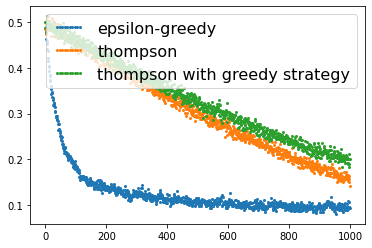

epsilon-greedy time(estimated for all simulations) is: 26.55282211303711
thompson time(estimated for all simulations) is: 90.19173407554626
thompson with greedy strategy time(estimated for all simulations) is: 88.42084050178528


In [ ]:

# Experiment 3
# Larger arms spaces to choose from
arm_count = 400 # number of arms in bandit
epsilon = 0.1
global_e_thompson = 0.1
stationary=True
experiment(arm_count,timesteps=1000, simulations=1000)


And we can also set up a fourth experiment where we increase both the arm count and timesetps even larger. And we can also see from the time that it save more time for the new thompson_plus_greedy algorithm.
The reason that the new thomspon_plus_greedy takes less time than the normal thompson is that normal thompson sampling will update each machines alpha and beta parameters(in this implementation it going through all machines, which costs more, it should only update the one gets picked but still costs) and feed into beta distribution which costs some time. But when it adds on e greedy, it will randomly give a machine so it will skip the recalcalculation to save time.

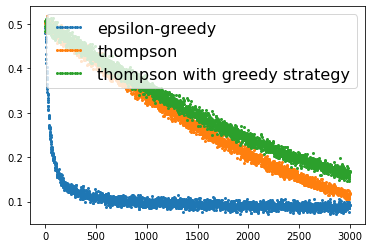

epsilon-greedy time(estimated for all simulations) is: 102.67515802383423
thompson time(estimated for all simulations) is: 544.1378190517426
thompson with greedy strategy time(estimated for all simulations) is: 514.2711265087128


In [ ]:

# Experiment 4
# Larger arms spaces to choose from
arm_count = 1000 # number of arms in bandit
epsilon = 0.1
global_e_thompson = 0.1
stationary=True
experiment(arm_count,timesteps=3000, simulations=1000)


### Summary for the first extension:
From the experiment above, we can summarize the performance of the new algorithm thompson_plus_greedy that partly adapted from two different algoriths.Overall it behaves kind of the same with thopson sampling algorithm, the reason is that it still use thompson sampling as its core action selection algorithm under a probability epsilon. It is still stable in most scenarios(stationary cases), but the regret it eventually converges is not as good as normal thompson since it sometimes will just pick action randomly. However, there is still some pros with this algorithm. Is that when the problem does not care about convergence and regret that much and care more about the time. The thompson_plus_greedy might be a candidate in that case. Also when it comes to a number of machines in a real world problem(lets say thousands, millions), time matters more. The normal e-greedy algorithm can definetly be chosen since it seems the most efficient. But if the case that it has to use thompson sampling(for example the case that we dont know the conversion rates for each machines in the first place but need to make assumstion on conversion rates). Then add this strategy may save a great amount of time by changing value of epsilon when machines are in a huge number and actions are also massive.

### Second extension: A real world problem

There are 10 possible advertisement a company want to use to promote a product. We should choose one of those 10 advertisement to attract the most customers. We have a sample of 10000 user feedbacks of the "click through rate" for each advertisement. We can see below we get the advertisement that predicted to be the one with higher conversion rate by using different sampling approaches.

First, we import the dataset got from https://www.kaggle.com/akram24/ads-ctr-optimisation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('Ads_CTR_Optimisation.csv')

In [5]:
dataset.head(10)


,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0
7,1,1,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0


Below are three algorithms with get_reward_regret() method removed since we will not use the default Bernolli(p) distribution in Bandit to simulate reward getting.

In [29]:
class EpsilonGreedy_Modified():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy-modified'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

In [7]:
class BetaAlgo_Modified():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernThompson_Modified(BetaAlgo_Modified):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson-modified'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    self.theta = np.random.beta(self.alpha, self.beta)
    return self.theta.argmax()


In [30]:
class BetaAlgo_Thompson_Plus_Greedy_Modified():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward
  
class BernThompsonEGreedy_Modified(BetaAlgo_Thompson_Plus_Greedy_Modified):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson with greedy strategy'
  
  def get_action(self):

    """ Bernouilli parameters are sampled from the beta"""
    if np.random.uniform(0,1) > global_e_thompson:
      theta = np.random.beta(self.alpha, self.beta)
      action = theta.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action

Below we modified the existing helper functions to satisfy our needs for the problem. 

In [31]:
import time
# Zeyu: Here we use the existing experiment function with some
# changes to adapt to the problem, note that I still keep the function name and
# some variables the same just to show that it extends from what's given above
def multi_plot_data(data):
    """
    Plot data showing which one get picked most
    """
    plt.hist(data)
    plt.title('Ads selections histogram')                                                    
    plt.ylabel('# of times each ad was selected')
   
    plt.show()
  
def simulate(simulations, arm_count, Algorithm):
  """ 
  'Simulate' the real world problem using algorithm given 
  Args:
    simulations: (int) number of actions
    arm_count: (int) number of machines, number of ads in our case
  Rertun:
    ads_selected: list of ad number selected
    total_reward: number of total reward got
  """

  ads_selected = [] 
  total_reward = 0
  bandit = Bandit(arm_count)
  algo = Algorithm(bandit)
  for i in range(timesteps):
    # Zeyu: We still call the get_action() method and let algo give us which
    # arm should be selected
    action = algo.get_action()
    ad = action
    ads_selected.append(ad)

    # Zeyu: Here instead of getting reward using Bernolli(p), we get reward from
    # data sample
    reward = dataset.values[i, ad]
    # Zeyu: Then we use a hacky way to update the the params based on the arm
    # selected and reward getting from data
    algo._update_params(action, reward)

    total_reward = total_reward + reward
  return ads_selected,total_reward
    

def experiment(arm_count, simulations, algorithm):
  """ 
  Standard setup across all experiments 
  Args:
    simulations: (int) number of actions
    arm_count: (int) number of machines, number of ads in our case
    algorithm: which algorithm use to model the problem
  Return:
    total_reward: number of total reward got
  """
  t0 = time.time()
  ads_selected,total_reward = simulate(simulations,arm_count, algorithm)
  t1 = time.time()
  multi_plot_data(ads_selected)
  total_time = t1 - t0
  return total_reward, total_time

Then we perform a few 'experiments' by using the algorithm defined above and the new thompson_plus_greedy algorithm on the dataset of a real world problem
First we apply the epsilon greedy algorithm with epsilon equals to 0.1. We can see that it eventually converges to a single advertisement selection which is Ad4. And the total time for it to run is pretty fast within 10000 data points.

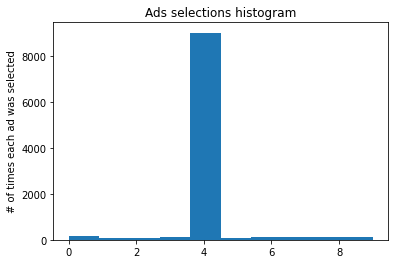

Total reward: 2528
Total time: 0.2794966697692871


In [33]:
# Experiment 1
epsilon = 0.1
arm_counts = 10
timesteps = 10000
total_reward,total_time = experiment(arm_counts, timesteps, EpsilonGreedy_Modified)
print("Total reward: " + str(total_reward))
print("Total time: " + str(total_time))

Then we perform the second experiment where we increase the value of epsilon. By observing the result, we can see that it still showing ad4 as the most selected ad but others are being picked more often than the first experiment. It is expected since we know that epsilon is the threshhold of "exploration" and "exploitation". The larger the value is, the more "exploration" it will perform which means more machnines will be picked randomly.

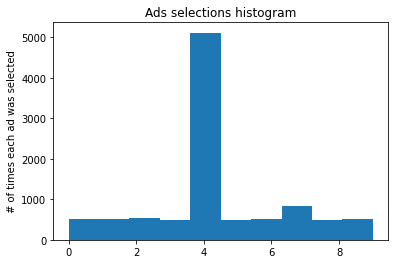

Total reward: 1898
Total time: 0.2510802745819092


In [15]:
# Experiment 2
epsilon = 0.5
arm_counts = 10
timesteps = 10000
total_reward,total_time = experiment(arm_counts, timesteps, EpsilonGreedy_Modified)
print("Total reward: " + str(total_reward))
print("Total time: " + str(total_time))

Now we perform the third experiment where we apply the thompson sampling algorithm. The output seems promising since it give us the same result as before but with relatively more total reward got out of it. Which indicate thompson sampling outperforms epsilon greedy by a little bit. 

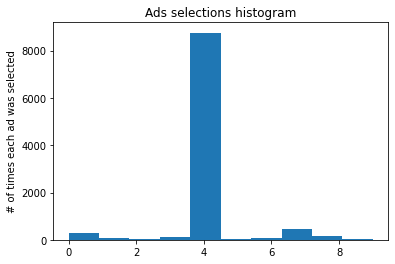

Total reward: 2577
Total time: 0.212937593460083


In [34]:
# Experiment 3
arm_counts = 10
timesteps = 10000
stationary=True
total_reward,total_time = experiment(arm_counts, timesteps, BernThompson_Modified)
print("Total reward: " + str(total_reward))
print("Total time: " + str(total_time))

Finally we perform our last experiment that uses the new thompson_plus_greedy algorithm. And choose epsilon to be 0.5 whcih means half explore half perform thompson sampling. And we can clearly see from the total reward is lower than any algorithm above, even than the epsilon greedy with same epsilon set.

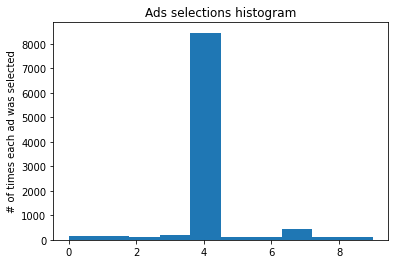

Total reward: 2458
Total time: 0.2440485954284668


In [40]:
# Experiment 4
arm_counts = 10
global_e_thompson = 0.1
timesteps = 10000
stationary=True
total_reward,total_time = experiment(arm_counts, timesteps, BernThompsonEGreedy_Modified)
print("Total reward: " + str(total_reward))
print("Total time: " + str(total_time))

As a summary, we can see that epsilon strategy and thompson sampling as well as the new thosmpson_plush greedy algorithm finishes the job and eventually let us know the ad that has relatively larger conversion rate based on those 10000 data points. The epsilon greedy performs not bad when in a real world problem. It gets decent total reard when epsilon is small, though it takes a bit more time compare to thompson sampling.
Thompson sampling, which seems to be the most stable algorithm, output the most total reward and taking ralatively shorter time.
The new algorithm, however, seems perform the worst with the same epsilon set in experimen1. It not given a good output of total reward and not running faster than the simple epsilon case. I was expecting to see it has a better performance with respect to time, but it does not seems has a significant improvement. Since we cannot see any good reason to use the new thompson_plus_greedy algorithm, it will not be recommended since we have two better options when consider epsilon greedy and thompson sampling individually.

## Reference:
https://www.kaggle.com/rupamshil/thompson-sampling